## Sfincs results: animation

We use the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to plot maps. This packages provides a simple interface to plot geographic data and add background satellite imagery.

In [1]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

### Read model results

The model results in sfincs_map.nc are saved as in a staggered grid format, see [SGRID convention](https://publicwiki.deltares.nl/display/NETCDF/Deltares+proposal+for+Staggered+Grid+data+model+(SGRID)). Here we show how to retrieve the face values and translate the dimensions from node indices (m, n) to (x, y) coordinates in order to plot the results on a map.

In [2]:
sfincs_root = "sfincs_riverine"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")

In [3]:
# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()

### Plot instantaneous water depths

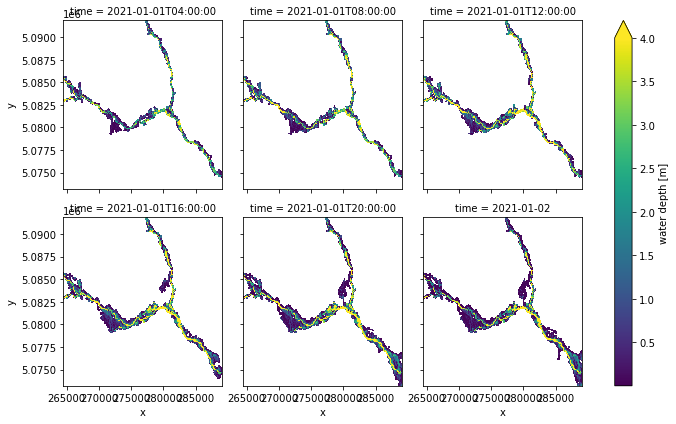

In [4]:
# h from sfincs_map contains the water depths for each cell face
# here we plot the water level every 4th hour
h = mod.results["h"].where(mod.results["h"] > 0)
h.attrs.update(long_name="water depth", unit="m")
h.sel(time=h["time"].values[4::4]).plot(col="time", col_wrap=3, vmax=4)

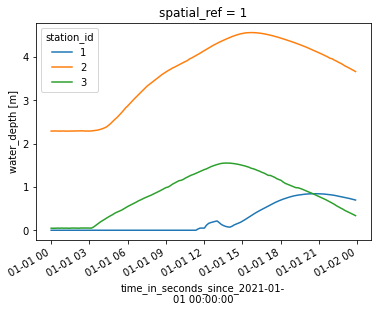

In [5]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)
_ = h_point.plot.line(
    x="time",
)

### Create animation

An animation is also simple to make with `matplotlib.animation` method. Here we add the surface water level in blue colors next to the overland flood depth with viridis colormap. 

In [6]:
# mask water depth
# rivmsk is a by product of the setup_river_geomerty setup component
rivmsk = mod.staticmaps["rivmsk"] == 1
hmin = 0.2
da_h = (mod.results["zs"] - mod.results["zb"]).where(~rivmsk)
da_h = da_h.where(da_h > hmin).drop("spatial_ref")
da_h.attrs.update(long_name="flood depth", unit="m")
# add water level inside permanent water bodies to plots
da_hriv = (mod.results["zs"] - mod.results["zb"]).where(rivmsk).drop("spatial_ref")
da_hriv.attrs.update(long_name="river water depth", unit="m")

In [7]:
# create hmax plot and save to mod.root/figs/sfincs_h.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
from matplotlib import animation

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}


def update_plot(i, da_h, cax_h, da_hriv=None, cax_hriv=None):
    da_hi = da_h.isel(time=i)
    t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_hi.values.ravel())
    if da_hriv is not None and cax_hriv is not None:
        da_hrivi = da_hriv.isel(time=i)
        cax_hriv.set_array(da_hrivi.values.ravel())


fig, ax = mod.plot_basemap(
    fn_out=None, variable=None, bmap="sat", plot_bounds=False, figsize=(11, 7)
)
cax_h = da_h.isel(time=0).plot(
    ax=ax, vmin=0, vmax=3, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)
# add water level inside permanent water bodies to plots
cax_hriv = da_hriv.isel(time=0).plot(
    ax=ax, vmin=0, vmax=5, cmap=plt.cm.bone, cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_h.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_h,
        cax_h,
        da_hriv,
        cax_hriv,
    ),
)

# to save to mp4
# ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())